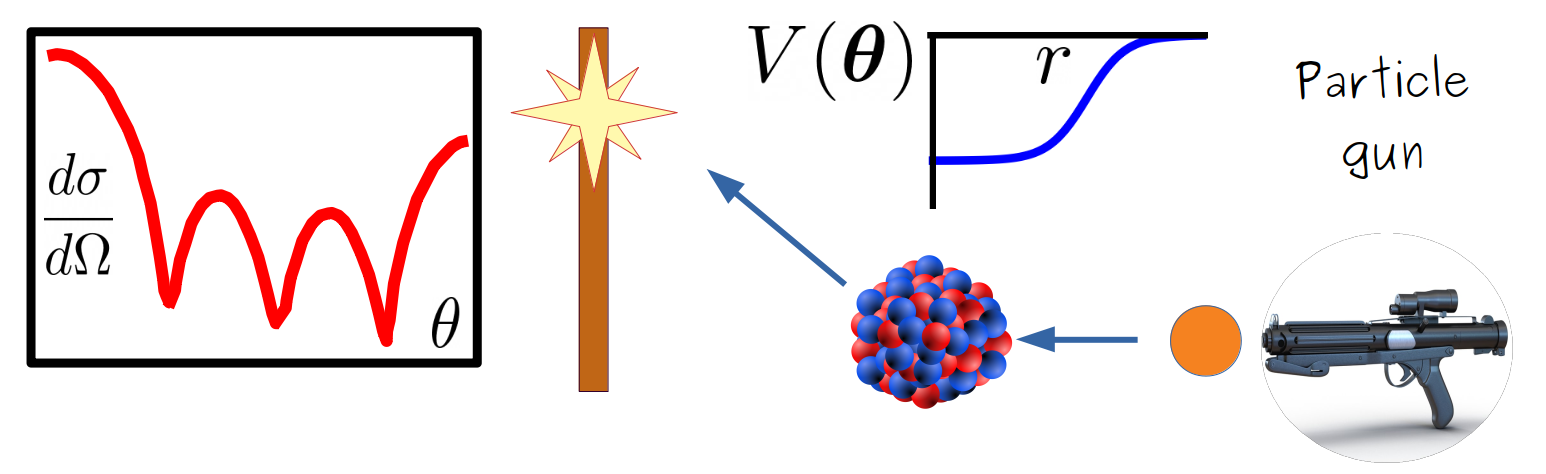

In [1]:
from IPython.display import Image
Image("bandframework/software/Bfrescox/Tutorial_I/frescox.png")

In [2]:
import os
import subprocess
import matplotlib.pyplot as plt

import scipy.stats as sps
from scipy import stats
import numpy as np
import pandas as pd
import pkg_resources
#pkg_resources.require("seaborn==0.11.0")
import seaborn as sns
import pylab
import random
from scipy.stats import qmc

In [3]:
# import os
# import subprocess
# import matplotlib.pyplot as plt

# commands = '''
#   export PATH=$PATH: ~/fewbody/Frescoxex/
#   cd bandframework/software/Bfrescox/Tutorial_I/python_scripts
#   mkdir frescox_outputs
#   frescox < frescox_inputs/D1048cadp.in > frescox_outputs/D1048cadp.out
#   frescox < frescox_inputs/LH1048cadp.in > frescox_outputs/LH1048cadp.out
# '''
# bashresults = subprocess.run(commands, capture_output=True, shell=True)

In [4]:

commands = '''
  cd bandframework/software/Bfrescox/Tutorial_I/python_scripts
  mkdir frescox_outputs
  mkdir fort_files
  ~/fewbody/Frescoxex/frescox < frescox_inputs/D1048cadp.in > frescox_outputs/D1048cadp.out
  cp fort.16 fort_files/40Ca_dxs
  ~/fewbody/Frescoxex/frescox < frescox_inputs/LH1048cadp.in > frescox_outputs/LH1048cadp.out
  cp fort.16 fort_files/40Ca_dxs_2
'''
bashresults = subprocess.run(commands, capture_output=True, shell=True)

In [5]:
os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
files = ['frescox_outputs/LH1048cadp.out', 'frescox_outputs/D1048cadp.out']
outs = []
for file in files:
    with open(file) as f:
        content = f.readlines()
        outs.append(content)

In [6]:
Rlist, slist = [], []
for out in outs:
    Rutherford = [] 
    sigma_omega_ratio = [] 
    for idline, line in enumerate(out):
        if '/R' in line:
            Rutherford.append(float(line.split()[3]))
        if (idline > 575) and ('X-S' in line):
            sigma_omega_ratio.append(float(line.split()[4]))
    
    Rlist.append(Rutherford)
    slist.append(sigma_omega_ratio)

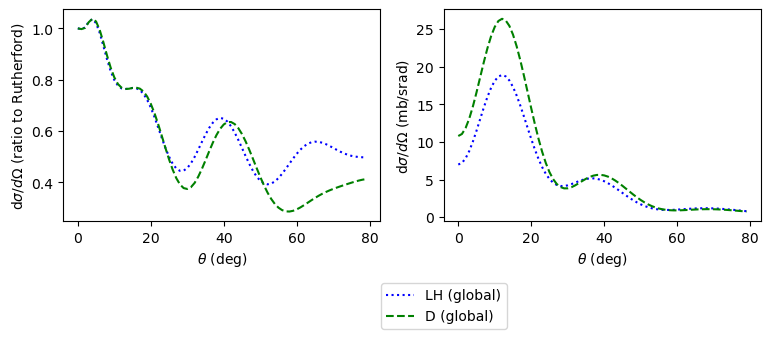

In [7]:
i = 0
fig, axes = plt.subplots(1, 2, figsize=(9,4))
for values in [Rlist, slist]:
    axes[i].plot(values[0][0:80], linestyle='dotted', c='blue', label='LH (global)')
    axes[i].plot(values[1][0:80], linestyle='dashed', c='green', label='D (global)')
    i += 1
fig.subplots_adjust(bottom=0.35)
plt.legend(bbox_to_anchor=(0, -0.4), loc='center')
axes[0].set_xlabel(r'$\theta$ (deg)')
axes[0].set_ylabel(r'd$\sigma/d\Omega$ (ratio to Rutherford)')
axes[1].set_xlabel(r'$\theta$ (deg)')
axes[1].set_ylabel(r'd$\sigma/d\Omega$ (mb/srad)')
plt.show()

In [8]:
def generate_input_file(parameter_values):
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
    file = 'frescox_inputs/48Ca_template.in'

    with open(file) as f:
        content = f.readlines()
        
    no_p = 0;
    for idx, line in enumerate(content):
        if 'XXXXX' in line:
            no_param = line.count('XXXXX')
            line_temp = line
            for i in range(no_param):
                line_temp = line_temp.replace("XXXXX", str(parameter_values[no_p]), 1) 
                no_p += 1
    
            content[idx] = line_temp
    
    f = open("frescox_inputs/frescox_temp_input.in", "a")
    f.writelines(content)
    f.close()       

In [9]:
def frescox_output(input_file='frescox_inputs/frescox_temp_input.in',
                   output_file='frescox_outputs/48Ca_temp.out'):

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_temp_input.in > frescox_outputs/48Ca_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    with open(output_file) as f:
        content = f.readlines()
        
    sigma_omega_ratio = [] 
    for idline, line in enumerate(content):
        if ('X-S' in line):
            sigma_omega_ratio.append(float(line.split()[4]))
        
    os.remove(input_file)
    os.remove(output_file)
    
    return sigma_omega_ratio

In [10]:
def frescox_run(theta):
    theta_list = theta.tolist()
    f_l = []
    for para_obs in theta_list:
        para_obs += [3.5,1,0.3]
        generate_input_file(para_obs)
        exp_output = frescox_output()
        f_l.append(exp_output)

    return np.asarray(f_l).T

In [11]:
def latin_sampling_3(samples):
    
    '''Given a number of samples, generate a training array.'''
    
    #n_train = 50
    
    random.seed(142857)

    
    Vv0 = 51.8

    Rv0 = 1.17

    av0 = 0.75
    
    ## Central value of parameter values
    alphaCentral = np.array([Vv0, Rv0, av0])


    #Creating a scale for how much the parameters will wiggle. Afterwards we sample from a latin hyper cube for training,
    #but use this scales also for the testing sampling which we do it with a Gaussian
    scaleTraining=0.3

    bounds_Vv_Scale = abs(Vv0*(scaleTraining))

    bounds_Rv_Scale = abs(Rv0*(scaleTraining))

    bounds_av_Scale = abs(av0*(scaleTraining))

    bounds_alpha=[bounds_Vv_Scale,bounds_Rv_Scale,bounds_av_Scale]
    
    bounds_Vv = [Vv0-bounds_Vv_Scale, Vv0+bounds_Vv_Scale]

    bounds_Rv = [Rv0-bounds_Rv_Scale, Rv0+bounds_Rv_Scale]

    bounds_av = [av0-bounds_av_Scale, av0+bounds_av_Scale]


    ## Bound array of the latin hypercube, min and max of the cube array in the form 
    ## array = [[V_min,V_max],[r_min,r_max],..]
    ##dim= (7,2)
    bounds = np.array([
    
        bounds_Vv,
        bounds_Rv,
        bounds_av,
    
    ])

    #random sampling inside the cube and creates the training potential array
    sampler = qmc.LatinHypercube(d=len(bounds))
    #sample = sampler.random(n_train)

    ## This is the array of (50,7) with the correct parameters. 
    ## This is important!!!!
    #train = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

    #potential empirical interpolation method, number of training parameters
    #n_train_EIM=1000
    random.seed(142857)
    sample_EIM = sampler.random(samples)
    ## training set parameters for the optica potential emulator
    train_EIM = qmc.scale(sample_EIM, bounds[:, 0], bounds[:, 1])
    
    return train_EIM

In [16]:
theta_tr = latin_sampling_3(100)
f_tr_1 = frescox_run(theta_tr)
x_tr = np.array(range(181)).reshape((181, 1))

In [17]:
theta_test = latin_sampling_3(100)
f_test_1 = frescox_run(theta_test)
x_test = np.array(range(181)).reshape((181, 1))

f_test = f_test_1
f_tr = f_tr_1

/Users/manuelfranciscocatacorarios/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


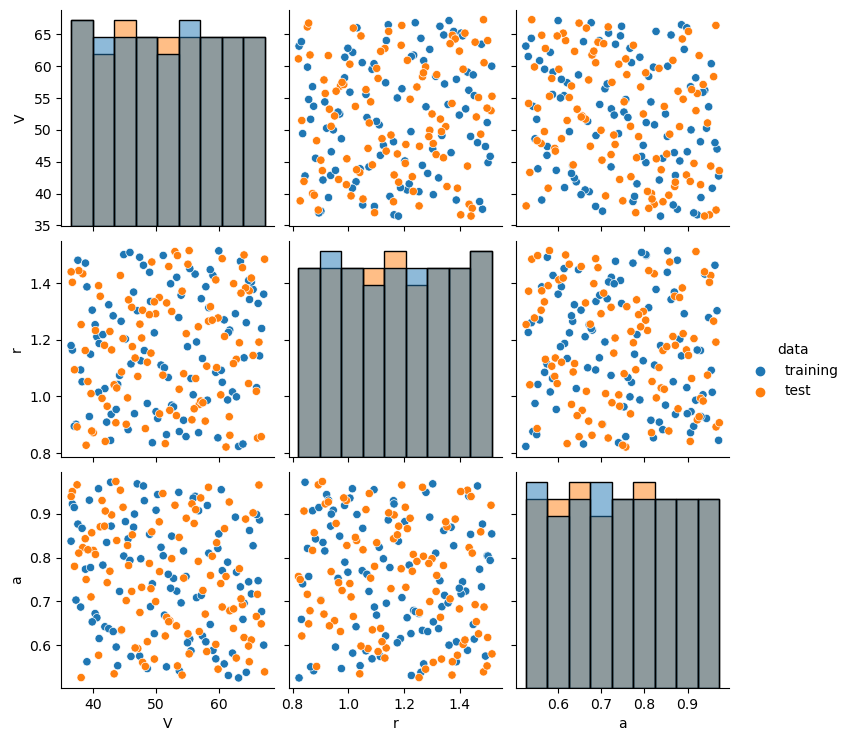

In [18]:
df = pd.DataFrame(theta_tr, columns = ['V','r','a'])
df_test = pd.DataFrame(theta_test, columns = ['V','r','a'])
df['data'] = 'training'
df_test['data'] = 'test'
frames = [df, df_test]
frames = pd.concat(frames)
sns.pairplot(frames, hue='data', diag_kind="hist")

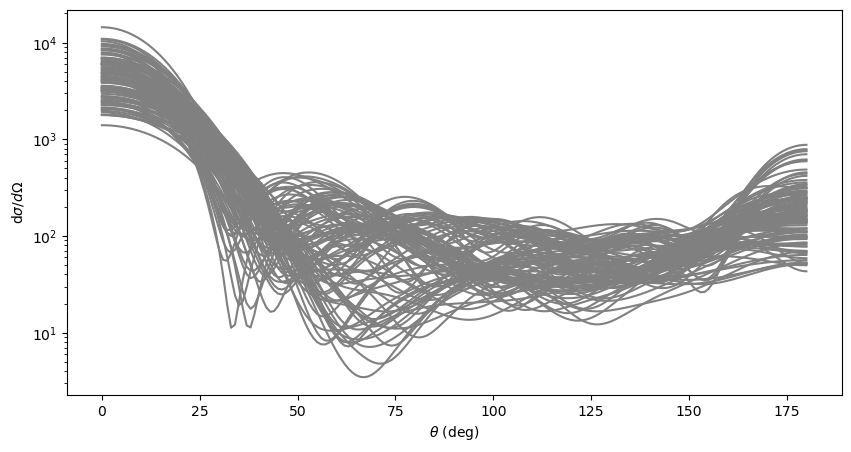

In [19]:
# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(f_tr.shape[1]):
    ax.plot(x_tr, f_tr[:, i], color='grey', zorder=1)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'd$\sigma/d\Omega$')
ax.set_yscale('log')
pylab.show()

In [ ]:
def generate_input_file_inelastic(parameter_values):
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
    file = 'frescox_inputs/test_template.in'

    with open(file) as f:
        content = f.readlines()
        
    no_p = 0;
    for idx, line in enumerate(content):
        if 'XXXXX' in line:
            no_param = line.count('XXXXX')
            line_temp = line
            for i in range(no_param):
                line_temp = line_temp.replace("XXXXX", str(parameter_values[no_p]), 1) 
                no_p += 1
    
            content[idx] = line_temp
    
    f = open("frescox_inputs/frescox_ine_temp_input.in", "a")
    f.writelines(content)
    f.close()   

In [ ]:
def frescox_output_inelastic(input_file='frescox_inputs/frescox_ine_temp_input.in',
                   output_file='frescox_outputs/test_temp.out'):

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_ine_temp_input.in > frescox_outputs/test_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    with open(output_file) as f:
        content = f.readlines()
        
    sigma_omega_ratio = [] 
    for idline, line in enumerate(content):
        if ('X-S' in line):
            sigma_omega_ratio.append(float(line.split()[4]))
        
    os.remove(input_file)
    os.remove(output_file)
    
    return sigma_omega_ratio

In [27]:
def extract_wave_functions(wave_file='fort.17'):
    
    with open(wave_file) as f:
        content = f.readlines()
        
    sigma_omega_ratio = []
    
    for idline, line in enumerate(content):
        if ('48.000000' not in line):
            sigma_omega_ratio.append(line.split())
        
    print(sigma_omega_ratio)
    
    return content

In [28]:
a = extract_wave_functions()

[['1', '0', '0.5', '0.5', '0', '0.5', '-0.5091732476', '0.1175700342', '0.00000000'], ['0.0000E+00', '0.0000E+00', '-5.4435E-03', '-7.9167E-02', '-1.0779E-02', '-1.5622E-01'], ['-1.5900E-02', '-2.2911E-01', '-2.0705E-02', '-2.9589E-01', '-2.5097E-02', '-3.5479E-01'], ['-2.8986E-02', '-4.0424E-01', '-3.2294E-02', '-4.4293E-01', '-3.4951E-02', '-4.6983E-01'], ['-3.6899E-02', '-4.8425E-01', '-3.8094E-02', '-4.8581E-01', '-3.8507E-02', '-4.7448E-01'], ['-3.8122E-02', '-4.5058E-01', '-3.6939E-02', '-4.1475E-01', '-3.4976E-02', '-3.6796E-01'], ['-3.2264E-02', '-3.1147E-01', '-2.8849E-02', '-2.4678E-01', '-2.4792E-02', '-1.7560E-01'], ['-2.0170E-02', '-9.9825E-02', '-1.5069E-02', '-2.1439E-02', '-9.5871E-03', '5.7513E-02'], ['-3.8303E-03', '1.3498E-01', '2.0879E-03', '2.0899E-01', '8.0504E-03', '2.7766E-01'], ['1.3938E-02', '3.3928E-01', '1.9633E-02', '3.9235E-01', '2.5021E-02', '4.3562E-01'], ['2.9994E-02', '4.6812E-01', '3.4453E-02', '4.8917E-01', '3.8310E-02', '4.9841E-01'], ['4.1490E-02',